# Libraries

In [1]:
from collections import Counter
import datetime
import itertools
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np
import optuna
import pandas as pd
import random
import re
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import time
import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertConfig
from transformers import get_linear_schedule_with_warmup

2025-05-16 07:06:11.038444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747379171.237918      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747379171.294590      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Utils

## Random Seed

In [2]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Preprocessing function

In [3]:
# Preprocessing functions

def preprocess_text_for_bert(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text) # Remove URLs
    text = re.sub(r"@\w+", "", text) # Remove mentions
    text = re.sub(r"#", "", text) # Keep hashtags (remove only '#')
    text = re.sub(r"[^\x00-\x7F]+", "", text) # Remove non-ASCII
    text = re.sub(r"\s+", " ", text) # Remove excess spaces
    return text.strip()

def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    
    # Correct the spelling mistakes
    text = re.sub(r" \b(luv) \b", "love", text)
    text = re.sub(r"\b(amzing) \b", "amazing", text)
    text = re.sub(r"\b(terible) \b", "terrible", text)
    text = re.sub(r"\b(excelent) \b", "excellent", text)
    text = re.sub(r"\b(performnce) \b", "performance", text)
    text = re.sub(r"\b(gud)\b", "good", text)
    text = re.sub(r"\b(vry)\b", "very", text)
    text = re.sub(r"\b(fantstic)\b", "fantastic", text)
    text = re.sub(r"\b(gr8)\b", "great", text)
    text = re.sub(r"\b(i'm)\b", "i am", text)
    text = re.sub(r"\b(horrble)\b", "horrible", text)
    text = re.sub(r"\b(don't)\b", "do not", text)
    text = re.sub(r"\b(did't)\b", "did not", text)
    text = re.sub(r"\b(dont)\b", "do not", text)
    text = re.sub(r"\b(didnt)\b", "did not", text)
    text = re.sub(r"\b(gotta)\b", "got to", text)
    text = re.sub(r"\b(waitin)\b", "waiting", text)
    text = re.sub(r"\b(thru)\b", "through", text)
    text = re.sub(r"\b('re)\b", "are", text)
    text = re.sub(r"\b(sis)\b", "sister", text)
    text = re.sub(r"\b(u)\b", "you", text)
    text = re.sub(r"\b(yeah)\b", "yes", text)
    text = re.sub(r"\b(yeh)\b", "yes", text)
    text = re.sub(r"\b(outta)\b", "out of", text)
    text = re.sub(r"\b(yah)\b", "you", text)
    text = re.sub(r"\b(foun)\b", "found", text)
    text = re.sub(r"\b(yah)\b", "you", text)
    text = re.sub(r"\b(ur)\b", "you are", text)
    text = re.sub(r"\b(sumtimes)\b", "sometimes", text)
    text = re.sub(r"\b(can't)\b", "can not", text)
    text = re.sub(r"\b(cannot)\b", "can not", text)
    text = re.sub(r"\b(commin)\b", "comming", text)
    text = re.sub(r"\b(gonna)\b", "going to", text)
    text = re.sub(r"\b(btw)\b", "by the way", text)
    text = re.sub(r"\b(at the moment)\b", "atm", text)
    text = re.sub(r"\b(oh my god)\b", "omg", text)
    text = re.sub(r"\b(laugh out loud)\b", "lol", text)
    text = re.sub(r"\b(it's)\b", "it is", text)
    text = re.sub(r"\b(its)\b", "it is", text)
    text = re.sub(r"\b('s)\b", " ", text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove hashtags
    text = re.sub(r'\#\w+', '', text)

    # Remove emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', '', text)

    # Remove mentions/tags
    text = re.sub(r'@\w+', '', text)

     # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove emojis
    text = re.sub(r'[^\w\s,;!?\'\"`~\-\.:]', '', text)

    # Replace words with 3 or more consecutive identical letters with just the first 3 letters
    text = re.sub(r'(\b\w*?)(\w)\2{2,}(\w*)\b', r'\1\2\3', text)

    # Remove non-ASCII characters (weird characters like ã, â, etc.)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove words that have only one letter
    text = re.sub(r'\b\w\b', '', text)
    
    # Remove special characters
    text = re.sub(r"[^\w\s]", " ", text)

    # Replace multiple spaces, tabs, or other whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove whitespace from the start and end
    text = text.strip()

    return text

## Print Confusion Matrix Function

In [4]:
# Compute and generate confusion matrix
def print_confusion_matrix(y_val, y_pred):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=2, cbar=False)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

## Print ROC curve function

In [5]:
# Compute and generate the ROC 
def print_roc(y_val, y_probs):
    # Get False Positive and True Positive Rates
    fpr, tpr, thresholds = roc_curve(y_val, y_probs)
    
    # Get the Area Under the Curve score
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Helper Functions

In [6]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times as `hh:mm:ss`
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Use GPU

In [7]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


I0000 00:00:1747379193.552322      19 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Make Installations

In [9]:
!pip install transformers
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c5c70a09e13cedaeb72ce73221856c4187ac88fd717249b1dc14757e0de6b853
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


# Get Dataset

## Create and Preprocess DataFrames

In [10]:
# Read CSVs to dfs
df_train = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/train_dataset.csv')
df_val = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/val_dataset.csv')
df_test = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/test_dataset.csv')

In [11]:
# Preprocess dfs
df_train_preprocessed = df_train.copy() 
df_train_preprocessed["Text"] = df_train_preprocessed["Text"].apply(preprocess_text_for_bert)
df_val_preprocessed = df_val.copy()
df_val_preprocessed["Text"] = df_val_preprocessed["Text"].apply(preprocess_text_for_bert)
df_test_preprocessed = df_test.copy()
df_test_preprocessed["Text"] = df_test_preprocessed["Text"].apply(preprocess_text_for_bert)

print("Create and Preprocess dataframes - Finished")

Create and Preprocess dataframes - Finished


## Get Sentences and Labels for Train Dataset

In [12]:
# Train Dataset
sentences_train = df_train_preprocessed.Text.values
labels_train = df_train_preprocessed.Label.values

# Validation Dataset
sentences_val = df_val_preprocessed.Text.values
labels_val = df_val_preprocessed.Label.values

# Test Dataset
sentences_test = df_test_preprocessed.Text.values

# Tokenization & Input Formatting

### Load the BERT tokenizer.

In [13]:
print('Loading DistilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Loading DistilBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Get Max Sentence Length

In [14]:
max_len = 0

# For every sentence...
for sent in sentences_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

for sent in sentences_val:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

for sent in sentences_test:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  118


## Tokenize Dataset Function

In [15]:
def tokenize_dataset(sentences, labels = None):
    
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []
    
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
    
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
    
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    if labels is not None:
        labels = torch.tensor(labels)

    # Combine inputs into a TensorDataset
    if labels is not None:
        dataset = TensorDataset(input_ids, attention_masks, labels)
    else:
        dataset = TensorDataset(input_ids, attention_masks)
    
    return dataset 

## Sample Dataset Function

In [16]:
# Used for large datasets, randomly takes a sample (sample_size should be values between 0 and 1)

def get_sample_from_dataset(dataset, sample_size):
    
    total_size = len(dataset)
    sample_size = int(sample_size * total_size)
    rest_size = total_size - sample_size
    sampled_dataset, rest_dataset = random_split(dataset, [sample_size, rest_size], generator=torch.Generator().manual_seed(seed))
    
    return sampled_dataset

## Create Dataloaders Function

```We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.```

In [17]:
# The DataLoaders needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
def get_dataloaders(batch_size):
    
    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order.
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    
    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

    return train_dataloader, validation_dataloader

# Train Model functions

## Initialize Model DistilBertForSequenceClassification Function

In [18]:
def model_init(hidden_dropout: float = 0.1,
               attention_dropout: float = 0.1):
    
    # Create a config
    config = DistilBertConfig.from_pretrained(
        "distilbert-base-uncased",
        num_labels = 2,
        dropout = hidden_dropout,
        attention_dropout = attention_dropout,
        output_attentions = False,
        output_hidden_states = False
    )

    # Load the pretrained weights with that config
    return DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        config = config
    )

## Train and Evaluate Model Function

In [19]:
# Train And Evaluate Model Function

def train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps,
                            hidden_dropout = 0.1, attention_dropout = 0.1, weight_decay = 0.0):
    
    # We'll store a number of quantities.
    training_stats = []
    
    # Reinitialize the model for each trial and tell pytorch to run this model on the GPU.
    model = model_init(hidden_dropout = hidden_dropout, attention_dropout = attention_dropout).cuda()
    
    # Initialize Optimizer.
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps = eps, weight_decay = weight_decay)
    
    # Create the learning rate scheduler to dynamically adjust the learning rate.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = total_steps)
    
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    
    # For each epoch...
    for epoch_i in range(epochs):
    
        # ========================================
        #               Training
        # ========================================
        
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        t0 = time.time() # Measure how long the training epoch takes.
        total_train_loss = 0 # Reset the total loss for this epoch.
        model.train() # Put the model into training mode.
    
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader and copy each tensor to the GPU with "to"
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
    
            # Clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
    
            # Perform a forward pass (evaluate the model on this training batch).
            result = model(
                b_input_ids,
                # token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
                return_dict=True
            )
            loss = result.loss
            logits = result.logits
    
            # Accumulate the training loss over all of the batches
            total_train_loss += loss.item()
            
            # Perform a backward pass to calculate the gradients.
            loss.backward()
    
            # Clip the norm of the gradients to 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.
            optimizer.step()
    
            # Update the learning rate.
            scheduler.step()
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
    
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
    
        
        # ========================================
        #               Validation
        # ========================================
        
        print("Running Validation...")
    
        t0 = time.time()
    
        # Put the model in evaluation mode
        model.eval()
    
        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
    
        # Create empty lists to store predictions and true labels
        all_preds = []
        all_labels = []
        all_probs = []
        
        # Evaluate data for one epoch
        for batch in validation_dataloader:
    
            # Unpack this validation batch from our dataloader and copy each tensor to the GPU with "to"
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
    
            # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                result = model(
                    b_input_ids,
                    # token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True
                )
    
            # Get the loss and "logits" output by the model.
            loss = result.loss
            logits = result.logits # The output values prior to applying an activation function like the softmax
    
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
    
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()  # Convert logits to probs
            label_ids = b_labels.to('cpu').numpy()
    
            # Get predicted labels (argmax over logits)
            preds = np.argmax(logits, axis=1)
    
            # For binary classification, keep the probability of class 1
            class1_probs = probs[:, 1]
            
            # Store predictions and true labels
            all_probs.extend(class1_probs)
            all_preds.extend(preds)
            all_labels.extend(label_ids)
    
            # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
    
        # Save validation results from final epoch
        if epoch_i == epochs - 1:
            final_labels = all_labels
            final_preds = all_preds
            final_probs = all_probs
        
         # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.4f}".format(avg_val_accuracy))
    
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation took: {:}".format(validation_time))
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    # Training Complete
    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
        
    return final_labels, final_preds, final_probs, training_stats, model, avg_val_loss

## Print evaluation function

In [20]:
def print_evaluate(final_labels, final_preds, final_probs, training_stats):

    # Print the Accuracy
    print("Validation Accuracy: {0:.4f}".format(training_stats[-1]['Valid. Accur.']))
    
    # Print the Classification Report
    print("\nClassification Report:")
    print(classification_report(final_labels, final_preds))
    
    # Display floats with two decimal places.
    pd.options.display.precision = 2
    
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch') # Use the 'epoch' as the row index.
    df_stats # Display the table.
    
    # Plot the learning curve.
    sns.set(style='darkgrid') # Use plot styling from seaborn. 
    sns.set(font_scale=1.5) # Increase the plot size and font size.
    plt.rcParams["figure.figsize"] = (8,4)
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(df_stats.index)
    plt.show()

    # Plot the validation accuracy.
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (8, 4)
    plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")
    plt.title("Validation Accuracy Across Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(df_stats.index)
    plt.show()

    # Print Confusion Matrix and ROC Curve
    print_confusion_matrix(final_labels, final_preds)
    print_roc(final_labels, final_probs)

# Final Model

## Get Dataloaders

In [21]:
# Get train dataset
train_dataset = tokenize_dataset(sentences_train, labels_train)
print("Generated Train Dataset")

# Get validation dataset
val_dataset = tokenize_dataset(sentences_val, labels_val)
print("Generated Validation Dataset")

# Get dataloaders
batch_size = 32
train_dataloader, validation_dataloader = get_dataloaders(batch_size)
print("Generated Dataloaders")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Generated Train Dataset
Generated Validation Dataset
Generated Dataloaders


## Train best Model

In [22]:
# Configure Hyper Parameters
epochs = 2
total_steps = len(train_dataloader) * epochs
learning_rate = 2e-5
eps = 1e-8
num_warmup_steps = 0
hidden_dropouts = 0.1
attention_dropout = 0.2
weight_decay = 0.2

# Train
results = train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps, 
                                   hidden_dropouts, attention_dropout, weight_decay)
final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of  4,638.    Elapsed: 0:00:08.
  Batch    80  of  4,638.    Elapsed: 0:00:16.
  Batch   120  of  4,638.    Elapsed: 0:00:23.
  Batch   160  of  4,638.    Elapsed: 0:00:30.
  Batch   200  of  4,638.    Elapsed: 0:00:38.
  Batch   240  of  4,638.    Elapsed: 0:00:45.
  Batch   280  of  4,638.    Elapsed: 0:00:53.
  Batch   320  of  4,638.    Elapsed: 0:01:00.
  Batch   360  of  4,638.    Elapsed: 0:01:08.
  Batch   400  of  4,638.    Elapsed: 0:01:15.
  Batch   440  of  4,638.    Elapsed: 0:01:23.
  Batch   480  of  4,638.    Elapsed: 0:01:30.
  Batch   520  of  4,638.    Elapsed: 0:01:38.
  Batch   560  of  4,638.    Elapsed: 0:01:45.
  Batch   600  of  4,638.    Elapsed: 0:01:53.
  Batch   640  of  4,638.    Elapsed: 0:02:00.
  Batch   680  of  4,638.    Elapsed: 0:02:08.
  Batch   720  of  4,638.    Elapsed: 0:02:15.
  Batch   760  of  4,638.    Elapsed: 0:02:23.
  Batch   800  of  4,638.    Elapsed: 0:02:30.
  Batch   840  of

## Evaluatation

Validation Accuracy: 0.8468

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     21197
           1       0.85      0.85      0.85     21199

    accuracy                           0.85     42396
   macro avg       0.85      0.85      0.85     42396
weighted avg       0.85      0.85      0.85     42396



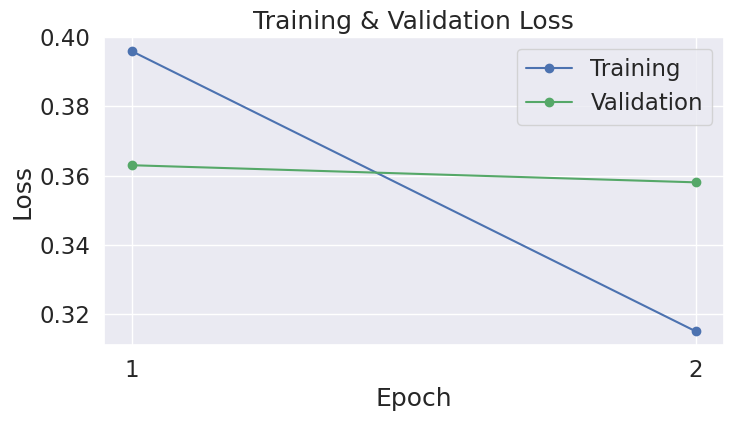

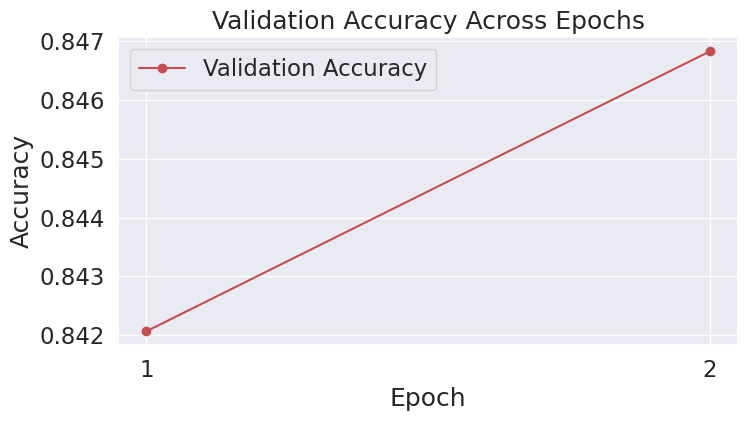

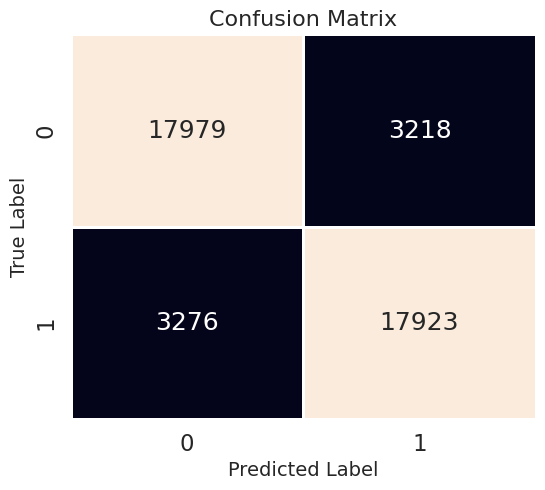

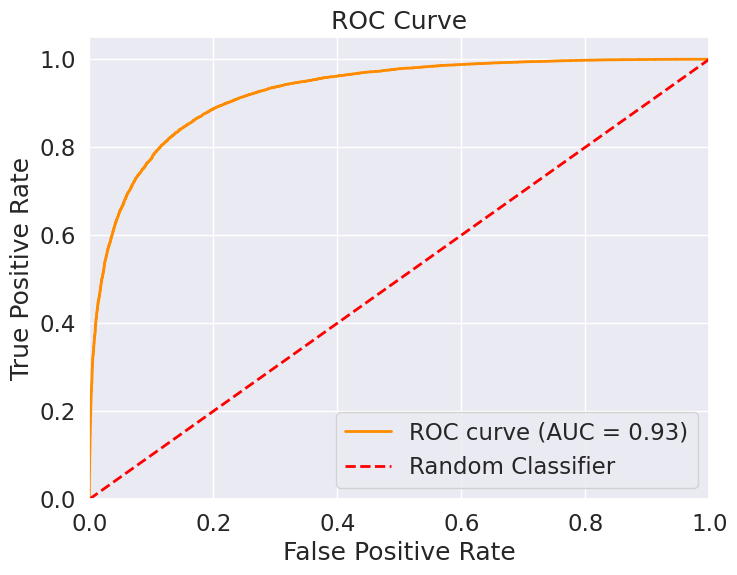

In [23]:
# Evaluation
print_evaluate(final_labels, final_preds, final_probs, training_stats)

# Performance on the Test Set

## Data Preparation

In [24]:
test_dataset = tokenize_dataset(sentences_test)
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Evaluate on Test Set

In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     # token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 37 test sentences...
    DONE.


In [26]:
# Flatten predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Submission

In [27]:
submission = pd.DataFrame({
    'ID': df_test_preprocessed['ID'],
    'Label': flat_predictions
})

submission.to_csv("/kaggle/working/submission.csv", index=False)

# Appendix

## Experiment 1 - Try BERT's fine-tuned parameters

In [28]:
# # Get train dataset
# train_dataset = tokenize_dataset(sentences_train, labels_train)
# # sample_size = 0.2 # Run the study for 20% of the training dataset 
# # train_dataset = get_sample_from_dataset(train_dataset, sample_size)
# print("Generated Train Dataset")

# # Get validation dataset
# val_dataset = tokenize_dataset(sentences_val, labels_val)
# print("Generated Validation Dataset")

# # Get dataloaders
# batch_size = 32
# train_dataloader, validation_dataloader = get_dataloaders(batch_size)
# print("Generated Dataloaders")

In [29]:
# # Configure Hyper Parameters
# epochs = 2
# total_steps = len(train_dataloader) * epochs
# learning_rate = 3e-5
# eps = 1e-8
# num_warmup_steps = 0
# hidden_dropouts = 0.1
# attention_dropout = 0.3
# weight_decay = 0.3

# # Train
# results = train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps, 
#                                    hidden_dropouts, attention_dropout, weight_decay)
# final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

In [30]:
# # Evaluation
# print_evaluate(final_labels, final_preds, final_probs, training_stats)

## Experiment 2 - Optuna (20% of training dataset, batch_size = 32)

In [31]:
# # Get train dataset
# train_dataset = tokenize_dataset(sentences_train, labels_train)
# sample_size = 0.2 # Run the study for 20% of the training dataset 
# train_dataset = get_sample_from_dataset(train_dataset, sample_size)
# print("Generated Train Dataset")

# # Get validation dataset
# val_dataset = tokenize_dataset(sentences_val, labels_val)
# print("Generated Validation Dataset")

# # Get dataloaders
# batch_size = 32
# train_dataloader, validation_dataloader = get_dataloaders(batch_size)
# print("Generated Dataloaders")

In [32]:
# # Suggest Hyper Parameters
# def suggest_hyperparameters(trial):

#     # Suggest epochs
#     epochs = trial.suggest_categorical('epoch', [2, 3])
    
#     # Suggest learning rate
#     learning_rate = trial.suggest_categorical('learning_rate', [5e-5, 3e-5, 2e-5])

#     # Suggest hidden dropout
#     hidden_dropout = trial.suggest_categorical('hidden_dropout', [0.1, 0.2, 0.3])

#     # Suggest attention dropout
#     attention_dropout = trial.suggest_categorical('attention_dropout', [0.1, 0.2, 0.3])

#     # Suggest weight decay
#     weight_decay = trial.suggest_categorical('weight_decay', [0.0, 0.1, 0.2, 0.3])
    
#     return epochs, learning_rate, hidden_dropout, attention_dropout, weight_decay

# # Objective Function
# def objective(trial):

#     # Sample hyperparameters
#     epochs, learning_rate, hidden_dropout, attention_dropout, weight_decay = suggest_hyperparameters(trial)

#     # Total number of training steps is [number of batches] x [number of epochs].
#     # (Note that this is not the same as the number of training samples).
#     total_steps = len(train_dataloader) * epochs

#     # Set num_warmup_steps to zero (default value in run_glue.py)
#     num_warmup_steps = 0
    
#     # Set eps
#     eps = 1e-8

#     # Do the training and evaluation
#     results = train_and_evaluate_model(
#         epochs, total_steps, learning_rate, eps, num_warmup_steps, 
#         hidden_dropout, attention_dropout, weight_decay
#     )
#     final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

#     return avg_val_loss  # minimize average validation loss

In [33]:
# # Run optuna study

# # Get the start time of the study
# study_start_time = time.time()

# sampler = optuna.samplers.RandomSampler(seed=42)

# study = optuna.create_study(direction = 'minimize', sampler = sampler, study_name = 'optimize_bert')

# study.optimize(objective, n_trials = 20)

# # Print study results
# print("The study took {:} (h:mm:ss)".format(format_time(time.time()-study_start_time)))
# print("")

# print('Number of finished trials:' , len(study.trials))
# print("")

# best_trial = study.best_trial
# print("Best Trial:")
# print(f"  Trial Number       : {best_trial.number}")
# print(f"  Value (avg_val_loss)  : {best_trial.value:.4f}")
# print("  Parameters:")
# for key, value in best_trial.params.items():
#     print(f"    {key:<18}: {value}")
# print(f"  Start Time         : {best_trial.datetime_start}")
# print(f"  Completion Time    : {best_trial.datetime_complete}")

In [34]:
# # Print the results in a table

# # Create a DataFrame from trials
# df_results = study.trials_dataframe(attrs=('number', 'value', 'params'))

# # Rename columns for clarity
# df_results = df_results.rename(columns={
#     'number': 'Trial',
#     'value': 'Validation Loss'
# })

# # Move 'Validation Loss' to front
# cols = ['Trial', 'Validation Loss'] + [col for col in df_results.columns if col not in ['Trial', 'Validation Loss']]
# df_results = df_results[cols]

# # Display the table
# display(df_results)

## Experiment 3 - Run Optuna Results

In [35]:
# # Get train dataset
# train_dataset = tokenize_dataset(sentences_train, labels_train)
# # sample_size = 0.2 # Run the study for 20% of the training dataset 
# # train_dataset = get_sample_from_dataset(train_dataset, sample_size)
# print("Generated Train Dataset")

# # Get validation dataset
# val_dataset = tokenize_dataset(sentences_val, labels_val)
# print("Generated Validation Dataset")

# # Get dataloaders
# batch_size = 32
# train_dataloader, validation_dataloader = get_dataloaders(batch_size)
# print("Generated Dataloaders")

In [36]:
# # Configure Hyper Parameters
# epochs = 2
# total_steps = len(train_dataloader) * epochs
# learning_rate = 2e-5
# eps = 1e-8
# num_warmup_steps = 0
# hidden_dropouts = 0.1
# attention_dropout = 0.2
# weight_decay = 0.2

# # Train
# results = train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps, 
#                                    hidden_dropouts, attention_dropout, weight_decay)
# final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

In [37]:
# # Evaluation
# print_evaluate(final_labels, final_preds, final_probs, training_stats)

## Experiment 4 - Experiment 3 with smaller batch size

In [38]:
# # Get train dataset
# train_dataset = tokenize_dataset(sentences_train, labels_train)
# # sample_size = 0.2 # Run the study for 20% of the training dataset 
# # train_dataset = get_sample_from_dataset(train_dataset, sample_size)
# print("Generated Train Dataset")

# # Get validation dataset
# val_dataset = tokenize_dataset(sentences_val, labels_val)
# print("Generated Validation Dataset")

# # Get dataloaders
# batch_size = 16
# train_dataloader, validation_dataloader = get_dataloaders(batch_size)
# print("Generated Dataloaders")

In [39]:
# # Configure Hyper Parameters
# epochs = 3
# total_steps = len(train_dataloader) * epochs
# learning_rate = 2e-5
# eps = 1e-8
# num_warmup_steps = 0
# hidden_dropouts = 0.1
# attention_dropout = 0.2
# weight_decay = 0.2

# # Train
# results = train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps, 
#                                    hidden_dropouts, attention_dropout, weight_decay)
# final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

In [40]:
# # Evaluation
# print_evaluate(final_labels, final_preds, final_probs, training_stats)

## Experiment 5 - Try warmup steps

`Bert models are pretrained, so jumping in with full learning rate right away can destabilize fine-tuning. A small warm-up (e.g. 0–10% of total steps) helps make training smoother and more effective. This works by linearly increasing the learning rate from 0 → target learning rate for the first num_warmup_steps`

In [41]:
# # Get train dataset
# train_dataset = tokenize_dataset(sentences_train, labels_train)
# # sample_size = 0.2 # Run the study for 20% of the training dataset 
# # train_dataset = get_sample_from_dataset(train_dataset, sample_size)
# print("Generated Train Dataset")

# # Get validation dataset
# val_dataset = tokenize_dataset(sentences_val, labels_val)
# print("Generated Validation Dataset")

# # Get dataloaders
# batch_size = 32
# train_dataloader, validation_dataloader = get_dataloaders(batch_size)
# print("Generated Dataloaders")

In [42]:
# # Configure Hyper Parameters
# epochs = 2
# total_steps = len(train_dataloader) * epochs
# learning_rate = 2e-5
# eps = 1e-8
# num_warmup_steps = int(0.05 * total_steps) # Try a warm up of 5% of total steps
# hidden_dropouts = 0.1
# attention_dropout = 0.2
# weight_decay = 0.2

# # Train
# results = train_and_evaluate_model(epochs, total_steps, learning_rate, eps, num_warmup_steps, 
#                                    hidden_dropouts, attention_dropout, weight_decay)
# final_labels, final_preds, final_probs, training_stats, model, avg_val_loss = results

In [43]:
# # Evaluation
# print_evaluate(final_labels, final_preds, final_probs, training_stats)